In [124]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/Users/kevinbrennan/Desktop/Final Project/Python Tests/Reverb (Python)/Comb Filter Reverberator')
from circular_buffer import CircularBuffer

#KYW inst
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')

# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

Min Value: -0.9484677314758301
Max Value: 0.9998999834060669


In [3]:
sd.play(data, fs)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_85718/1738035919.py:19: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits
/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_85718/1738035919.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, fs/2])  # Set x-axis limits


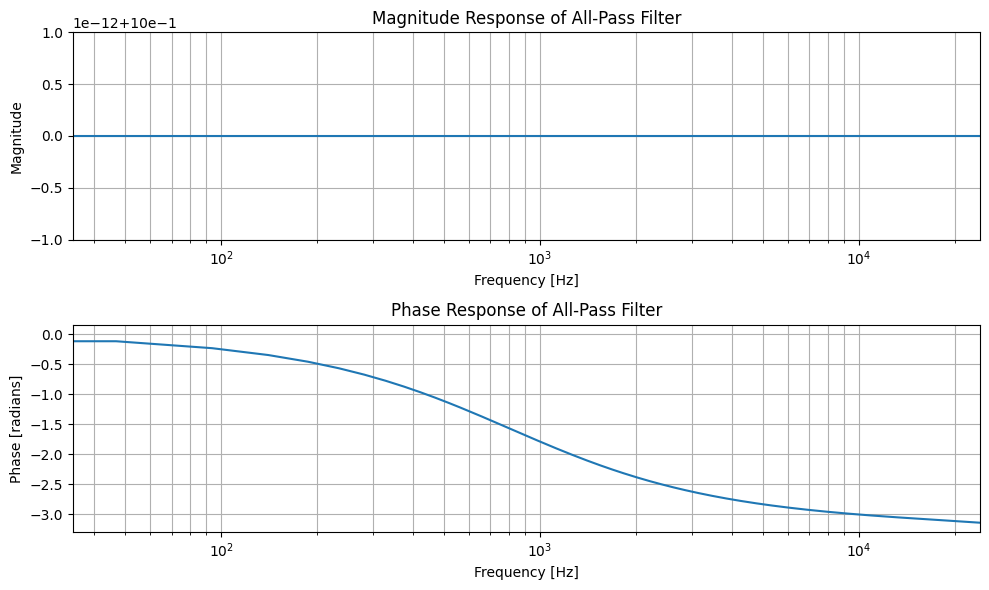

In [125]:
a1 = -0.9
num = [a1, 1]
den = [1, a1]

w1, H1 = signal.freqz(num, den)

# Convert frequencies to Hz
freq_hz = w1 * (fs / (2 * np.pi))

# Plot magnitude and phase responses in Hz
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_hz, np.abs(H1))
plt.title('Magnitude Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits


plt.subplot(2, 1, 2)
plt.plot(freq_hz, np.angle(H1))
plt.title('Phase Response of All-Pass Filter')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radians]')
plt.grid(which='both')
plt.xscale('log')  # Set x-axis to a logarithmic scale
plt.xlim([0, fs/2])  # Set x-axis limits


plt.tight_layout()
plt.show()

In [129]:
M = 1000

dataCpyL = data[:,0]
dataCpyR = data[:,1]

for i in range(1, M):
    data_filtL = signal.lfilter(num, den, dataCpyL)
    data_filtR = signal.lfilter(num, den, dataCpyR)
    dataCpyL = data_filtL
    dataCpyR = data_filtR


#
stereoFiltered = np.vstack((dataCpyL, dataCpyR))
stereoFiltered = np.transpose(stereoFiltered) 


In [137]:

# Delaying All Pass Filter Reverberator
# From Pirkles book, using circular buffer
# instead of allpass filter
delay_time = 0.2
BufferSize = int(round(delay_time * fs))
g = 0.25

# Setting up a buffer for each channel
CircBufL = CircularBuffer(BufferSize)
CircBufR = CircularBuffer(BufferSize)

# Array to hold delayed signal
output = np.zeros([len(stereoFiltered) + BufferSize,2])

for i in range(len(stereoFiltered) + BufferSize):
    if i < len(stereoFiltered):
        sample_in_L = stereoFiltered[i,0]
        sample_in_R = stereoFiltered[i,1]

    delayed_L = CircBufL.get_sample_from_buffer()
    delayed_R = CircBufR.get_sample_from_buffer()

    sum_fdbk_L = sample_in_L + (g * delayed_L)
    sum_fdbk_R = sample_in_R + (g * delayed_R)

    CircBufL.push_sample_to_buffer(sum_fdbk_L)
    CircBufR.push_sample_to_buffer(sum_fdbk_R)

    output[i,0] = (-g * sample_in_L) + ((1 - pow(g,2)) * delayed_L)
    output[i,1] = (-g * sample_in_R) + ((1 - pow(g,2)) * delayed_R)

# Normalize the audio data
wet_reverb_out = output / np.max(np.abs(output))

In [138]:
sd.play(wet_reverb_out, fs)

In [139]:
padded_data = np.pad(data, ((0, len(wet_reverb_out) - len(data)), (0, 0)))
wetAmt = 0.4
wet_dry_output = (wetAmt * wet_reverb_out) + ((1-wetAmt) * padded_data)

In [140]:
sd.play(wet_dry_output, fs)

In [141]:
sd.play(stereoFiltered, fs)

/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_52449/1004670092.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times0, frequencies0, 10 * np.log10(Sxx0), shading='auto')


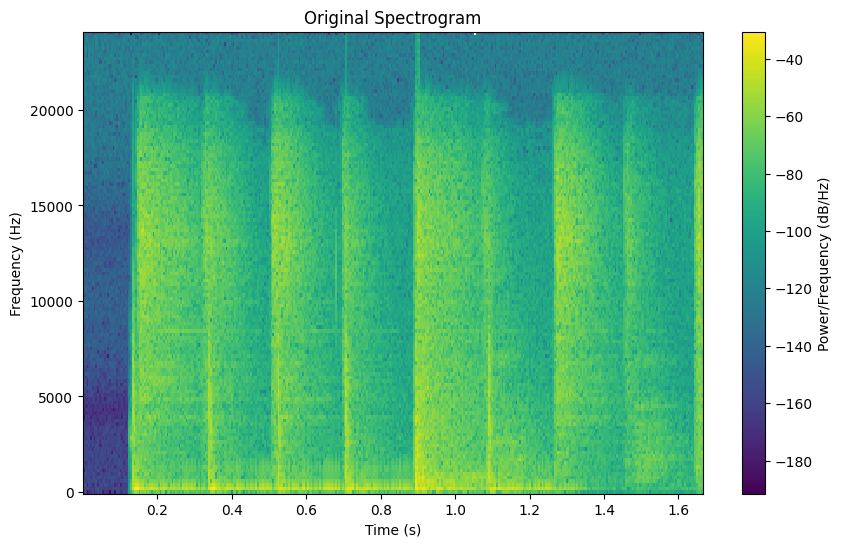

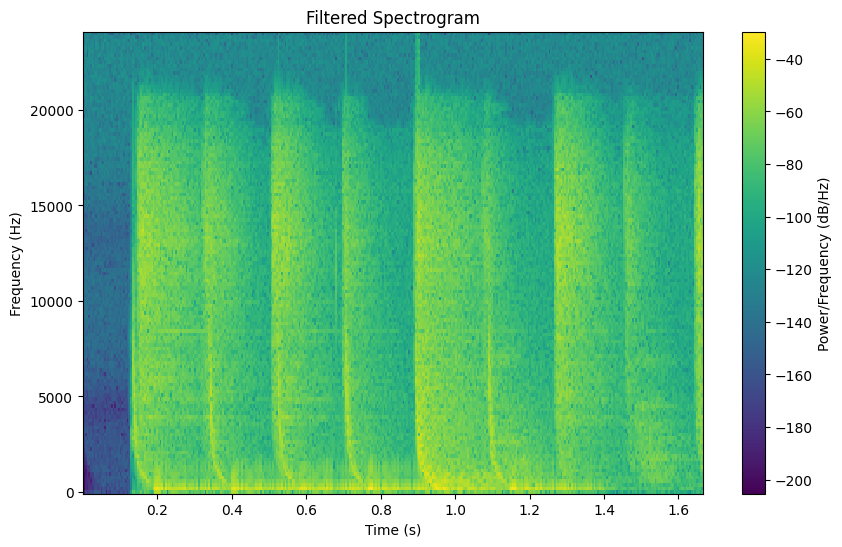

In [278]:
# Compute the spectrogram
frequencies0, times0, Sxx0 = signal.spectrogram(data[0:80000,0], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times0, frequencies0, 10 * np.log10(Sxx0), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Original Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

# Compute the spectrogram
frequencies, times, Sxx = signal.spectrogram(stereoFiltered[0:80000,0], fs)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='auto')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.title('Filtered Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()